In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# windows (memory leak fix)
os.environ["OMP_NUM_THREADS"] = '1'

In [3]:
# load in the file
file_path = 'myopia.csv'
df= pd.read_csv(file_path)
df

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY,MYOPIC
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1,0
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,6,0.678,22.400000,3.663,3.803,14.93,2,0,7,3,14,37,1,0,1
614,6,0.665,22.500000,3.570,3.378,15.56,6,0,1,0,8,10,1,1,0
615,6,1.834,22.940001,3.624,3.424,15.89,8,0,0,0,4,4,1,1,0
616,6,0.665,21.920000,3.688,3.598,14.64,12,2,1,0,15,23,0,0,0


In [4]:
# ensure no nulls
df.dropna(inplace=True)

In [5]:
df.shape

(618, 15)

In [6]:
# remove the diagnosis column and save it for later
myopic = df['MYOPIC']

In [7]:
df2 = df.drop(['MYOPIC'], axis=1)

In [8]:
df2.head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0


In [9]:
df2.shape

(618, 14)

In [10]:
# Standardize data
X = StandardScaler().fit_transform(df2)

In [11]:
# initialize a PCA method that explains 90% of variance
pca = PCA(n_components=.9)

In [12]:
# apply to data
myopic_pca = pca.fit_transform(X)

In [13]:
# note the pca only removed 4 fields
print(myopic_pca[0])

[ 0.53550271  1.14500427 -1.38501894  0.11600593 -3.22669052 -1.92845879
 -1.95889156 -1.92299652  0.02675285  0.17814386]


In [14]:
from sklearn.manifold import TSNE

In [15]:
# perform t-SNE on the reduced dimensional data and trying various perplexity values finally settling on 1 per field
tsne = TSNE(learning_rate=618, perplexity=14)
tsne_features = tsne.fit_transform(myopic_pca)

C:\Users\drami\anaconda3\envs\PythonData38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


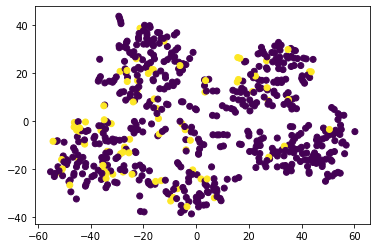

In [16]:
# a preliminary look at the data along with the known cases of myopia
plt.scatter(tsne_features[:,0], tsne_features[:,1], c=myopic)
plt.show()

#### There are what appears to be 5 clusters. Lets see what k-means finds.  With the actual cases of myopia shown in the plot, they appear to be in all of the visible spatial clusters, though since this doesn't represent the whole picture, there may be more to it than the visual display.

In [17]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(myopic_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
elbow = pd.DataFrame(elbow_data)
elbow.head()

C:\Users\drami\anaconda3\envs\PythonData38\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,k,inertia
0,1,7948.905345
1,2,6794.293482
2,3,6030.953812
3,4,5662.799045
4,5,5381.970825


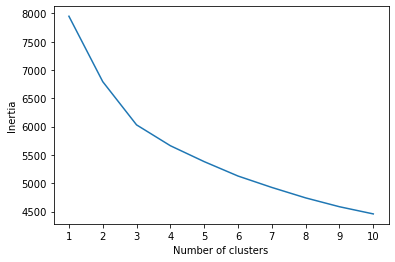

In [18]:
# Plot an elbow curve to find the best values for k
plt.plot(elbow['k'], elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Looks like the best 'k' value is at 3 as that appears to be the last most visible 'elbow'.

In [19]:
km = KMeans(n_clusters=3, random_state=42)
km.fit(myopic_pca)
cluster_pred = km.predict(myopic_pca)

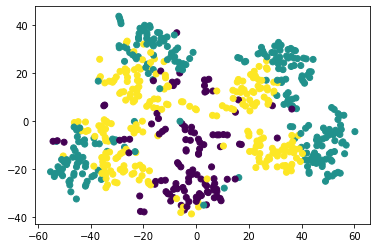

In [20]:
plt.scatter(tsne_features[:,0], tsne_features[:,1], c=cluster_pred)
plt.show()

#### Here it looks like distict clusters and thus the case can be made that 3 clusters would be a good choice.

In [21]:
# just looking at some other values of 'k'
km2 = KMeans(n_clusters=5, random_state=42)
km2.fit(myopic_pca)
cluster_pred2 = km2.predict(myopic_pca)

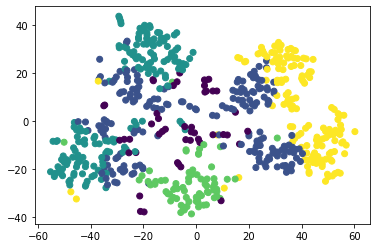

In [22]:
plt.scatter(tsne_features[:,0], tsne_features[:,1], c=cluster_pred2)
plt.show()

#### After looking at a few different 'k' values just to see if there is good match with the spatial appearance, I find that 3 still looks best.  So for recommendation for the doctors, I would say to split the patients into 3 groups based on the data.